<a href="https://colab.research.google.com/github/Jorgellamocca/GEFS_forecast/blob/main/sudamerica_gefs_forecast_35_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
A brief introduction to the NOAA GEFS forecast dataset transformed into an analysis-ready, cloud-optimized format by dynamical.org.

Dataset documentation: https://dynamical.org/catalog/noaa-gefs-forecast-35-day/


In [1]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Do

Usando init_time: 2025-03-31 00:00:00


<ipython-input-2-80d9bdba6bf2>:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.02)  # Más juntos
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: Download

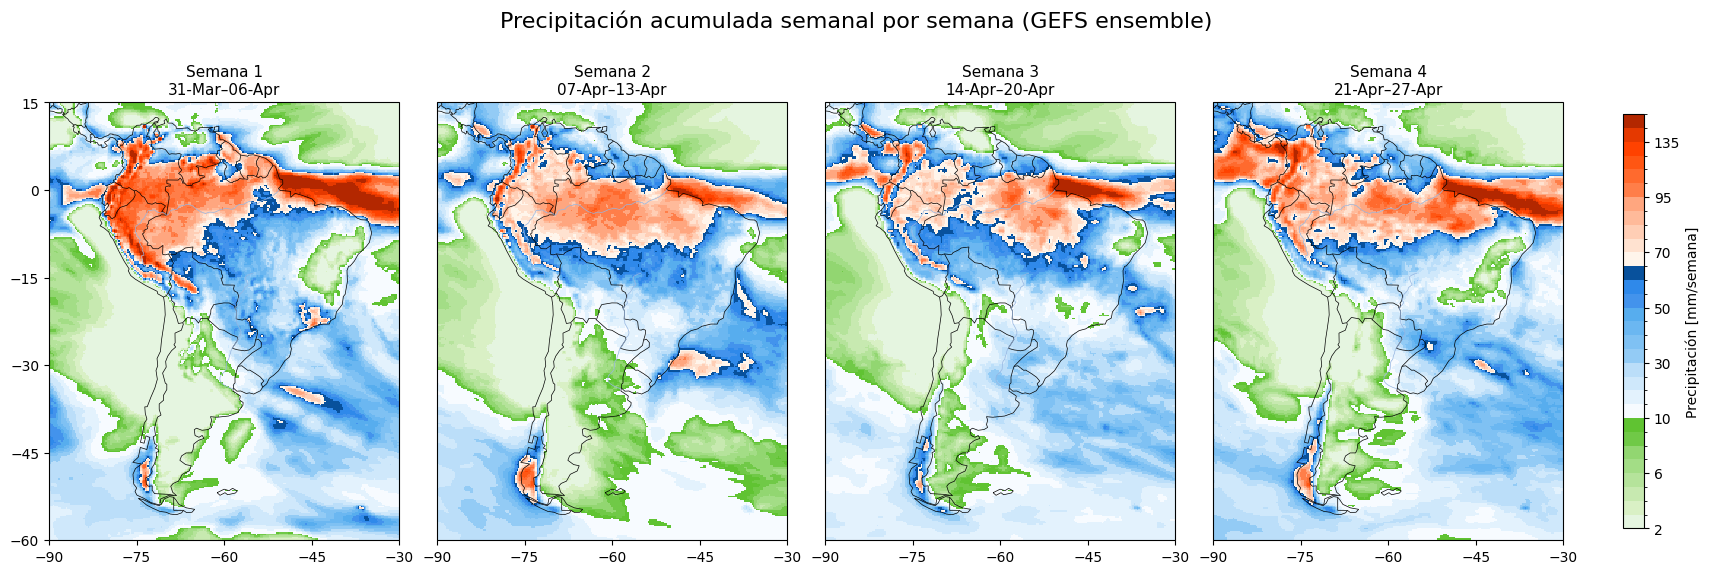

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# 1️⃣ Abrir dataset GEFS desde Zarr
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# 2️⃣ Fecha más reciente
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init))

# 3️⃣ Subconjunto Sudamérica y promedio ensemble
ds_mean = (
    ds.sel(init_time=latest_init)
    .sel(latitude=slice(15, -60), longitude=slice(-90, -30))
    .mean(dim="ensemble_member")
)

# 4️⃣ Semana 1 a 4: lead_time hasta 27 días
ds_weeks = ds_mean.sel(lead_time=slice("0h", "27d"))

# 5️⃣ Paso en segundos
lead_times = ds_weeks.lead_time
dt = lead_times.diff("lead_time").dt.total_seconds()
last_dt = dt[-1]
dt_full = xr.concat([dt, last_dt.expand_dims(lead_time=1)], dim="lead_time")
dt_seconds = xr.DataArray(dt_full.values, coords={"lead_time": ds_weeks.lead_time}, dims=["lead_time"])

# 6️⃣ Convertir a mm
precip_mm = ds_weeks["precipitation_surface"] * dt_seconds

# 7️⃣ Coordenada temporal real
forecast_time = ds_weeks.init_time + ds_weeks.lead_time
precip_mm = precip_mm.assign_coords(forecast_time=forecast_time)
precip_mm = precip_mm.swap_dims({"lead_time": "forecast_time"})

# 8️⃣ Agrupar por día calendario
precip_daily = precip_mm.groupby("forecast_time.date").sum(dim="forecast_time")

# 9️⃣ Preparar semanas
semanas = {
    "Semana 1": slice(0, 7),
    "Semana 2": slice(7, 14),
    "Semana 3": slice(14, 21),
    "Semana 4": slice(21, 28),
}

# 🔟 Paleta personalizada
colors_prec = (
    ["#E5F5E0", "#D9F0C5", "#C7E9B0", "#B5E39B", "#A3DD86", "#92D671", "#81D05C", "#70C947", "#60C332"] +
    ["#F7FBFF", "#E3F2FD", "#CFE8FB", "#BBDEF9", "#A7D5F7", "#93CBF5", "#7FC1F3", "#6BB7F1", "#57ADEE", "#4393EC", "#2F89EA", "#1B7FE8", "#08519C"] +
    ["#FFF5EB", "#FFE2D0", "#FFCEB5", "#FFBA9A", "#FFA67F", "#FF9264", "#FF7E49", "#FF6A2E", "#FF5613", "#FF4200", "#E53900", "#CC3000", "#B32700"]
)
levels_prec = list(range(2, 10, 1)) + list(range(10, 85, 5)) + list(range(85, 160, 10))
cmap_prec = mcolors.ListedColormap(colors_prec)
norm_prec = mcolors.BoundaryNorm(levels_prec, cmap_prec.N)

# 🎨 Crear figura con 4 subplots en una fila
fig, axes = plt.subplots(1, 4, figsize=(17, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
plt.subplots_adjust(wspace=0.02)  # Más juntos

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    # Acumulado semanal
    prec = precip_daily.isel(date=rango).sum(dim="date")

    # Fechas del rango
    week_dates = precip_daily.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b")
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b")

    # Mapa base
    ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)

    # Etiquetas solo en eje izquierdo e inferior
    if i == 0:
        ax.set_yticks(range(-60, 16, 15), crs=ccrs.PlateCarree())
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())
        ax.tick_params(labelleft=True, labelbottom=True)
    else:
        ax.tick_params(labelleft=False, labelbottom=True)
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())

    # Plot
    mesh = ax.pcolormesh(prec.longitude, prec.latitude, prec, cmap=cmap_prec, norm=norm_prec, shading="auto")
    ax.set_title(f"{semana}\n{start_date}–{end_date}", fontsize=11)

# Colorbar global
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Precipitación [mm/semana]")

# Título general
plt.suptitle("Precipitación acumulada semanal por semana (GEFS ensemble)", fontsize=16, y=1.02)
plt.show()


In [ ]:
#PERU

Usando init_time: 2025-04-08


<ipython-input-5-3d86bc09db78>:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.02)


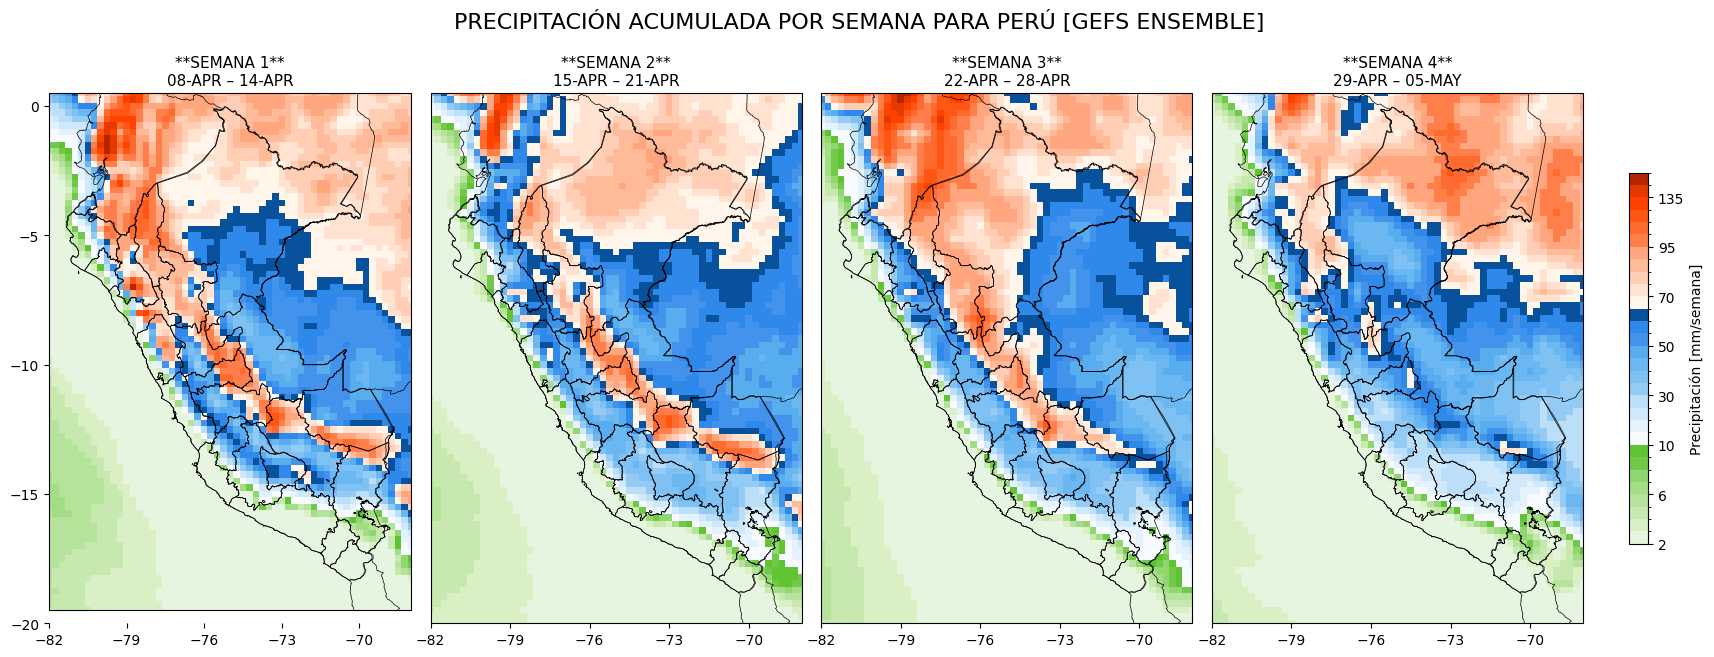

Imagen guardada como: precip_semanal_peru_20250408.png


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import tempfile
import requests
import os

# 0️⃣ Descargar shapefile de departamentos de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}

tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    response = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(response.content)

# Leer shapefile con GeoPandas
gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))

# 1️⃣ Abrir dataset GEFS desde Zarr
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# 2️⃣ Fecha más reciente
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))

# 3️⃣ Subconjunto PERÚ y promedio ensemble
ds_mean = (
    ds.sel(init_time=latest_init)
    .sel(latitude=slice(0.5, -19.5), longitude=slice(-82, -68))
    .mean(dim="ensemble_member")
)

# 4️⃣ Semana 1 a 4: lead_time hasta 27 días
ds_weeks = ds_mean.sel(lead_time=slice("0h", "27d"))

# 5️⃣ Paso en segundos
lead_times = ds_weeks.lead_time
dt = lead_times.diff("lead_time").dt.total_seconds()
last_dt = dt[-1]
dt_full = xr.concat([dt, last_dt.expand_dims(lead_time=1)], dim="lead_time")
dt_seconds = xr.DataArray(dt_full.values, coords={"lead_time": ds_weeks.lead_time}, dims=["lead_time"])

# 6️⃣ Convertir a mm
precip_mm = ds_weeks["precipitation_surface"] * dt_seconds

# 7️⃣ Coordenada temporal real
forecast_time = ds_weeks.init_time + ds_weeks.lead_time
precip_mm = precip_mm.assign_coords(forecast_time=forecast_time)
precip_mm = precip_mm.swap_dims({"lead_time": "forecast_time"})

# 8️⃣ Agrupar por día calendario
precip_daily = precip_mm.groupby("forecast_time.date").sum(dim="forecast_time")

# 9️⃣ Preparar semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# 🔟 Paleta personalizada
colors_prec = (
    ["#E5F5E0", "#D9F0C5", "#C7E9B0", "#B5E39B", "#A3DD86", "#92D671", "#81D05C", "#70C947", "#60C332"] +
    ["#F7FBFF", "#E3F2FD", "#CFE8FB", "#BBDEF9", "#A7D5F7", "#93CBF5", "#7FC1F3", "#6BB7F1", "#57ADEE", "#4393EC", "#2F89EA", "#1B7FE8", "#08519C"] +
    ["#FFF5EB", "#FFE2D0", "#FFCEB5", "#FFBA9A", "#FFA67F", "#FF9264", "#FF7E49", "#FF6A2E", "#FF5613", "#FF4200", "#E53900", "#CC3000", "#B32700"]
)
levels_prec = list(range(2, 10, 1)) + list(range(10, 85, 5)) + list(range(85, 160, 10))
cmap_prec = mcolors.ListedColormap(colors_prec)
norm_prec = mcolors.BoundaryNorm(levels_prec, cmap_prec.N)

# 🎨 Crear figura con 4 subplots en una fila
fig, axes = plt.subplots(1, 4, figsize=(17, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
plt.subplots_adjust(wspace=0.02)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    prec = precip_daily.isel(date=rango).sum(dim="date")
    week_dates = precip_daily.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()

    ax.set_extent([-82, -68, -19.5, 0.5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Agregar límites departamentales
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

    if i == 0:
        ax.set_yticks(range(-20, 1, 5), crs=ccrs.PlateCarree())
        ax.set_xticks(range(-82, -67, 3), crs=ccrs.PlateCarree())
        ax.tick_params(labelleft=True, labelbottom=True)
    else:
        ax.tick_params(labelleft=False, labelbottom=True)
        ax.set_xticks(range(-82, -67, 3), crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(prec.longitude, prec.latitude, prec, cmap=cmap_prec, norm=norm_prec, shading="auto")
    ax.set_title(f"**{semana}**\n{start_date} – {end_date}", fontsize=11)

# Colorbar global
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Precipitación [mm/semana]")

# TÍTULO GENERAL
plt.suptitle("PRECIPITACIÓN ACUMULADA POR SEMANA PARA PERÚ [GEFS ENSEMBLE]", fontsize=16, y=1.07)

# 💾 Guardar imagen
fecha_str = pd.to_datetime(latest_init).strftime("%Y%m%d")
output_file = f"precip_semanal_peru_{fecha_str}.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Imagen guardada como: {output_file}")



Usando init_time: 2025-04-25


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Imagen guardada como: tmax_miembro_0_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_1_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_2_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_3_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_4_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_5_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_6_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_7_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_8_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_9_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_10_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_11_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_12_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_13_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_14_semanal_peru_20250425.png
Imagen guardada como: tmax_miembro_15_semanal_peru

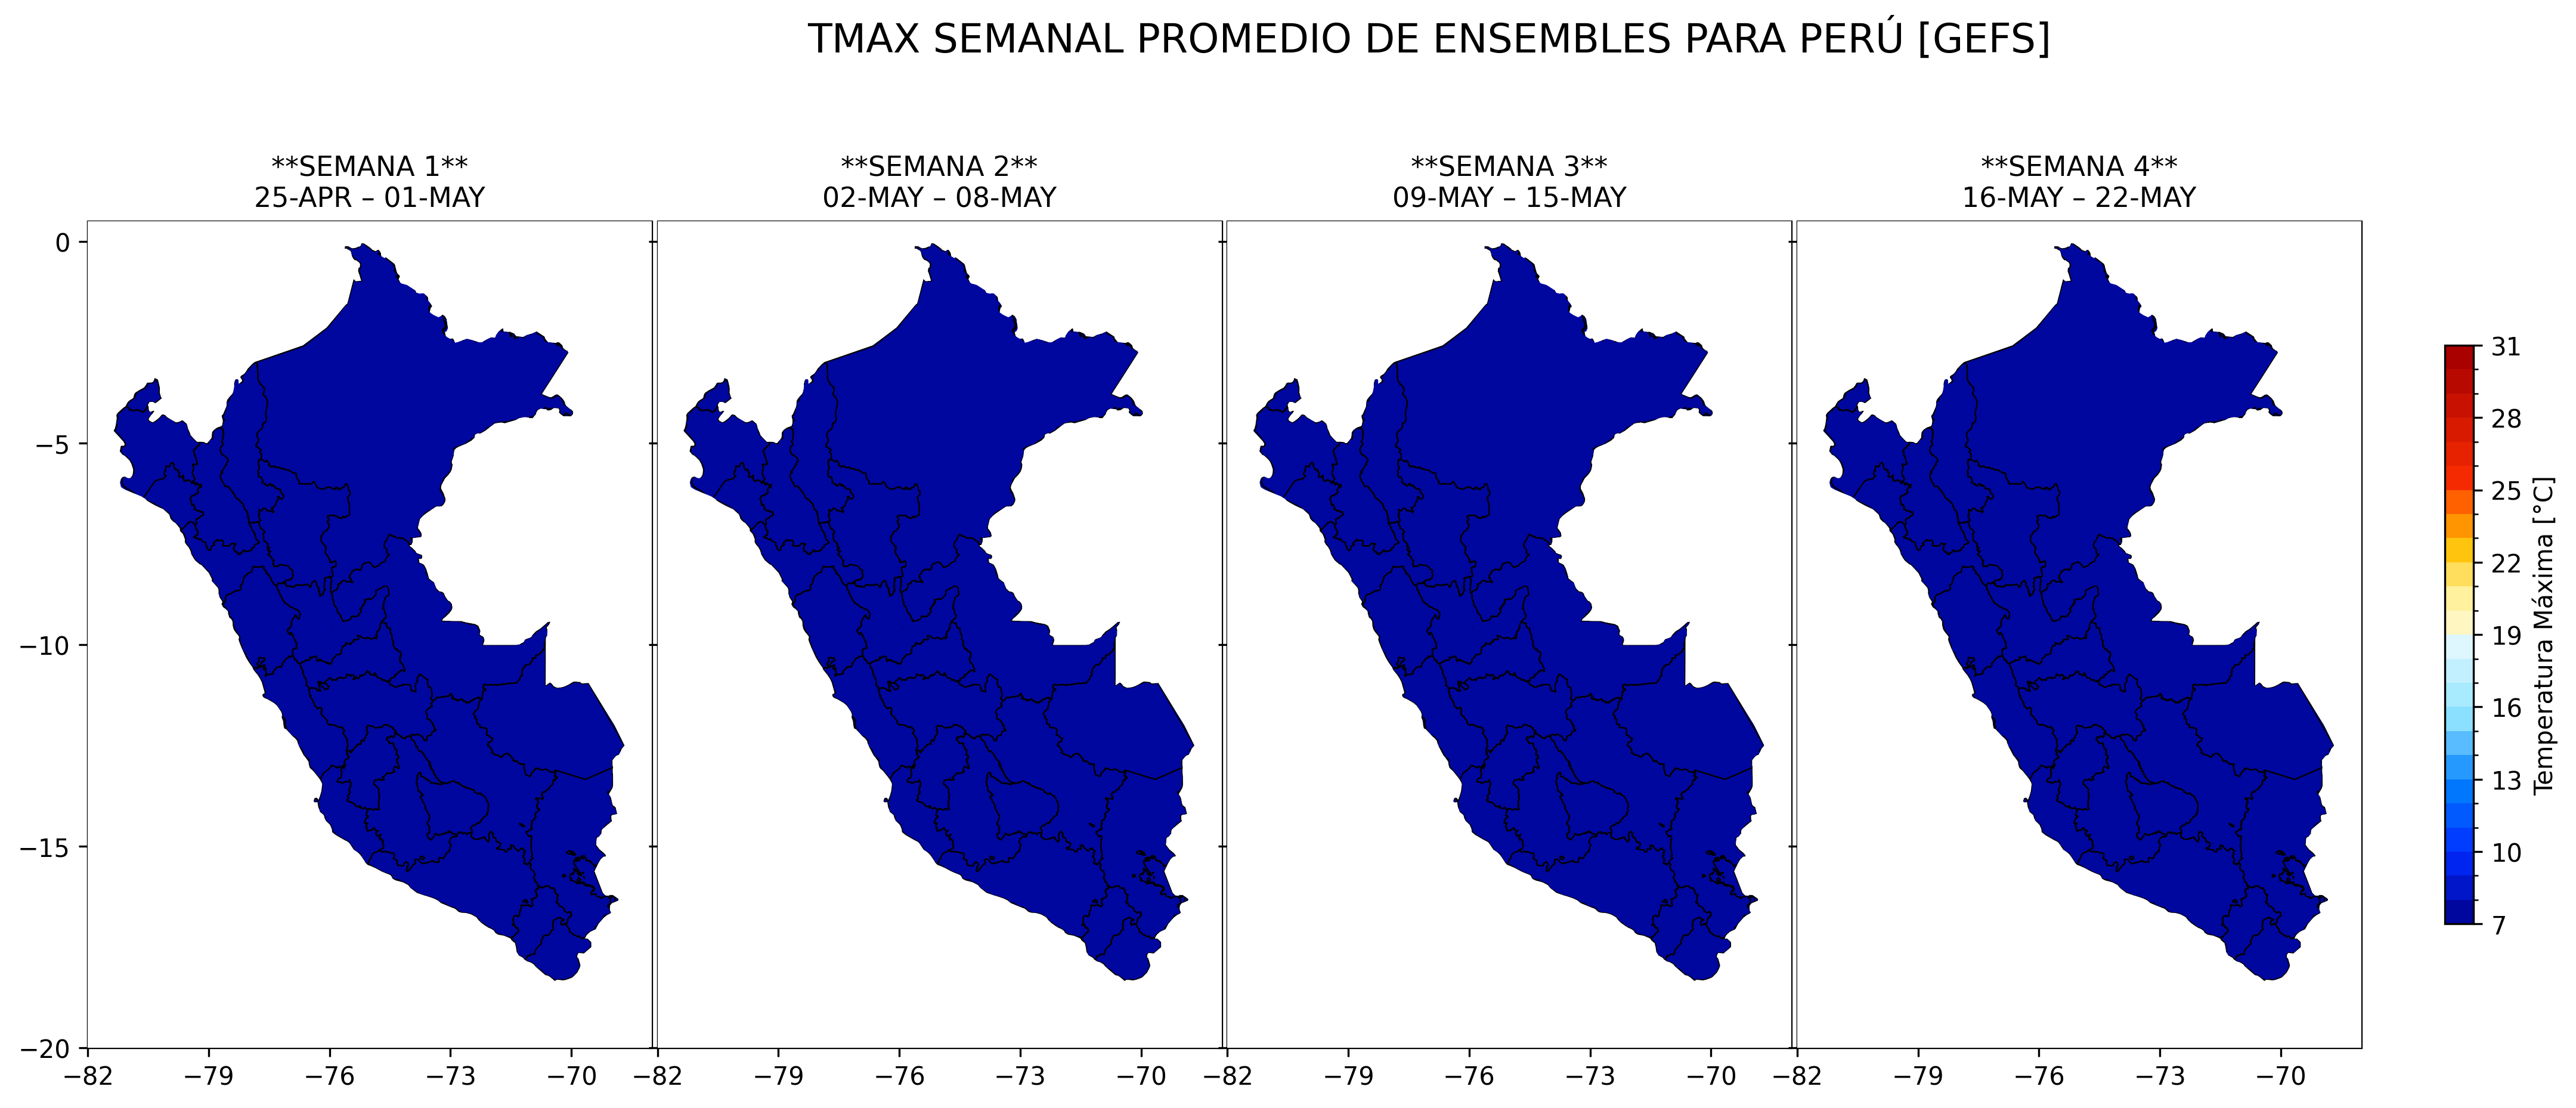

Imagen guardada como: tmax_ensmean_semanal_peru_20250425.png


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import numpy as np
import tempfile
import requests
import os

# Descargar shapefiles principales y de máscara
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}
shapefiles_extra = {
    "SUDA_NUEVO_SIN_PERU_3.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "SUDA_NUEVO_SIN_PERU_3.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "SUDA_NUEVO_SIN_PERU_3.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shx",
}

tempdir = tempfile.mkdtemp()
for files in [shapefiles, shapefiles_extra]:
    for filename, url in files.items():
        response = requests.get(url)
        with open(os.path.join(tempdir, filename), "wb") as f:
            f.write(response.content)

gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))
gdf_suda = gpd.read_file(os.path.join(tempdir, "SUDA_NUEVO_SIN_PERU_3.shp"))

# Dataset GEFS

ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))

ds_sub = ds.sel(init_time=latest_init).sel(latitude=slice(0.5, -19.5), longitude=slice(-82, -68))

# Extraer datos por miembro
ds_members = ds_sub.sel(lead_time=slice("0h", "27d"))
tmax_all = ds_members["maximum_temperature_2m"] - 273.15  # Convertir de K a °C
forecast_time = ds_members.init_time + ds_members.lead_time
tmax_all = tmax_all.assign_coords(forecast_time=forecast_time)
tmax_all = tmax_all.swap_dims({"lead_time": "forecast_time"})
tmax_daily_all = tmax_all.groupby("forecast_time.date").mean(dim="forecast_time")

semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# Paleta de colores personalizada para temperatura
colors = ['#00079F', '#0116C8', '#0125F0', '#013DFF', '#015AFE', '#0177FE', '#2699FE', '#58BCFE',
          '#8AE0FE', '#A8EAFE', '#C3F0FF', '#DEF7FF',  '#FFF6C1', '#FFF19D', '#FFDE5D', '#FFC50E',
          '#FF9501', '#FF6101', '#F62A00', '#E72200', '#D71A00', '#C81101', '#B80901', '#A90100']
cmap_custom = mcolors.ListedColormap(colors)
norm_custom = mcolors.BoundaryNorm(boundaries=np.arange(7, 32, 1), ncolors=len(colors))

# Figura por miembro
members = tmax_all.ensemble_member.values
for member in members:
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
    fig.subplots_adjust(wspace=0.01, hspace=0)

    extent = [-82, -68, -19.5, 0.5]
    x_ticks = range(-82, -67, 3)
    y_ticks = range(-20, 1, 5)

    for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
        tmax_member = tmax_daily_all.sel(ensemble_member=member)
        tmax_avg = tmax_member.isel(date=rango).mean(dim="date")
        week_dates = tmax_member.date.values[rango]
        start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
        end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()

        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
        ax.tick_params(labelbottom=True, labelleft=(i == 0))

        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        mesh = ax.pcolormesh(tmax_avg.longitude, tmax_avg.latitude, tmax_avg, cmap=cmap_custom, norm=norm_custom, shading="nearest")
        gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, zorder=5)
        gdf_suda.plot(ax=ax, color='white', linewidth=0, zorder=10)

        ax.set_title(f"**{semana}**\n{start_date} – {end_date}", fontsize=11)

    cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
    cbar.set_label("Temperatura Máxima [°C]")

    plt.suptitle(f"TMAX SEMANAL - MIEMBRO {member} [GEFS]", fontsize=16, y=1.07)
    output_file = f"tmax_miembro_{member}_semanal_peru_{pd.to_datetime(latest_init).strftime('%Y%m%d')}.png"
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.05)
    plt.close()
    print(f"Imagen guardada como: {output_file}")

# Promedio general
fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
fig.subplots_adjust(wspace=0.01, hspace=0)
tmax_prom = tmax_daily_all.mean(dim="ensemble_member")

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    tmax_avg = tmax_prom.isel(date=rango).mean(dim="date")
    week_dates = tmax_prom.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i == 0))

    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    mesh = ax.pcolormesh(tmax_avg.longitude, tmax_avg.latitude, tmax_avg, cmap=cmap_custom, norm=norm_custom, shading="nearest")
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, zorder=5)
    gdf_suda.plot(ax=ax, color='white', linewidth=0, zorder=10)

    ax.set_title(f"**{semana}**\n{start_date} – {end_date}", fontsize=11)

cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Temperatura Máxima [°C]")

plt.suptitle("TMAX SEMANAL PROMEDIO DE ENSEMBLES PARA PERÚ [GEFS]", fontsize=16, y=1.07)
output_file = f"tmax_ensmean_semanal_peru_{pd.to_datetime(latest_init).strftime('%Y%m%d')}.png"
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.05)
plt.show()
print(f"Imagen guardada como: {output_file}")


<ipython-input-6-5bbdc43fb9a4>:10: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_meta = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
<ipython-input-6-5bbdc43fb9a4>:10: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_meta = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
<ipython-input-6-5bbdc43fb9a4>:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/lat

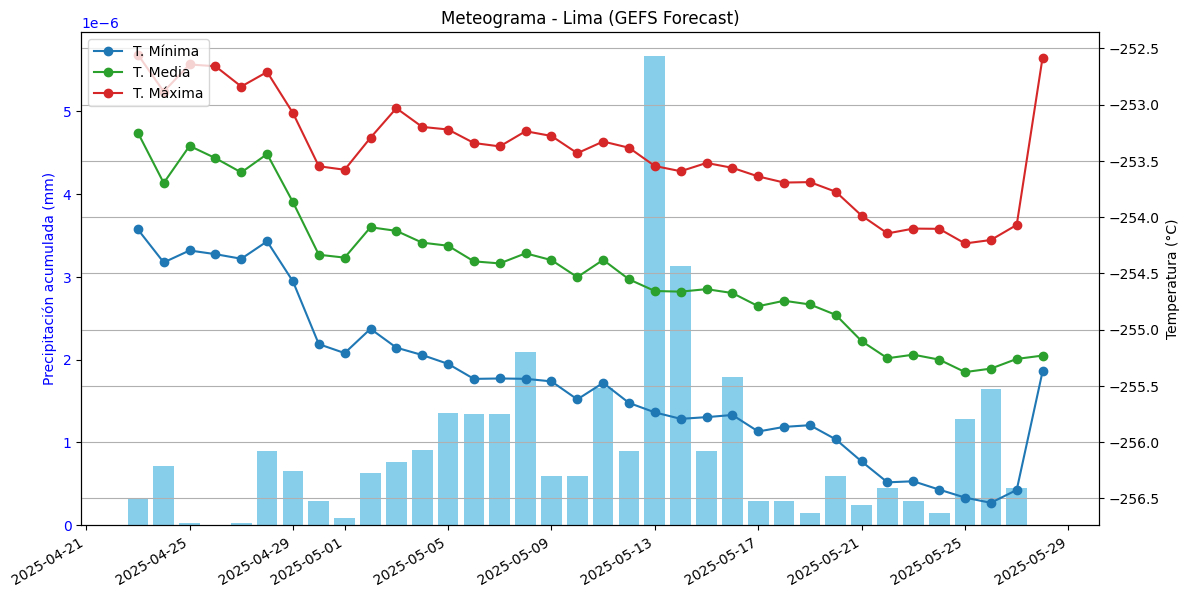

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Coordenadas de Lima
lat_lima = -12.046
lon_lima = -77.042

# Abrir solo metadatos para detectar la fecha más reciente
ds_meta = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
latest_init = ds_meta.init_time.max().values

# Abrir solo las variables necesarias
vars_needed = ["maximum_temperature_2m", "minimum_temperature_2m", "temperature_2m", "precipitation_surface"]
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)[vars_needed]

# Seleccionar sólo Lima y el último init_time
ds = ds.sel(init_time=latest_init, latitude=lat_lima, longitude=lon_lima, method="nearest").mean("ensemble_member")

# Convertir coordenada temporal
forecast_time = ds.init_time + ds.lead_time
ds = ds.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# Agrupar por día
tmax = ds["maximum_temperature_2m"]
tmin = ds["minimum_temperature_2m"]
tmed = ds["temperature_2m"]
prec = ds["precipitation_surface"]

tmax_daily = tmax.groupby("forecast_time.date").mean("forecast_time")
tmin_daily = tmin.groupby("forecast_time.date").mean("forecast_time")
tmed_daily = tmed.groupby("forecast_time.date").mean("forecast_time")
prec_daily = prec.groupby("forecast_time.date").sum("forecast_time")

dates = pd.to_datetime(tmax_daily.date.values)

# Gráfico del meteograma
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras de precipitación (eje izquierdo)
ax1.bar(dates, prec_daily, color='skyblue', label="Precipitación")
ax1.set_ylabel("Precipitación acumulada (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Líneas de temperatura (eje derecho)
ax2 = ax1.twinx()
ax2.plot(dates, tmin_daily, label="T. Mínima", color='tab:blue', marker='o')
ax2.plot(dates, tmed_daily, label="T. Media", color='tab:green', marker='o')
ax2.plot(dates, tmax_daily, label="T. Máxima", color='tab:red', marker='o')
ax2.set_ylabel("Temperatura (°C)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Formato
fig.autofmt_xdate()
fig.tight_layout()
ax2.legend(loc='upper left')
plt.title("Meteograma - Lima (GEFS Forecast)")
plt.grid(True)
plt.show()


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import tempfile
import requests
import os

# 1. Descargar shapefile de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}

tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    response = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(response.content)

gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))

# 2. Abrir dataset GEFS
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))

# 3. Subset de región (Pacífico Sur)
ds_sub = ds.sel(init_time=latest_init).sel(latitude=slice(10, -50), longitude=slice(-120, -60))
ds_members = ds_sub.sel(lead_time=slice("0h", "27d"))

pressure_all = ds_members["pressure_reduced_to_mean_sea_level"] / 100  # de Pa a hPa
u10_all = ds_members["wind_u_10m"]
v10_all = ds_members["wind_v_10m"]

# 4. Ajuste de tiempo
forecast_time = ds_members.init_time + ds_members.lead_time
pressure_all = pressure_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
u10_all = u10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
v10_all = v10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# 5. Agrupar diario
pressure_daily_all = pressure_all.groupby("forecast_time.date").mean(dim="forecast_time")
u10_daily_all = u10_all.groupby("forecast_time.date").mean(dim="forecast_time")
v10_daily_all = v10_all.groupby("forecast_time.date").mean(dim="forecast_time")

# 6. Definir semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# 7. Promedio ensemble
pressure_prom = pressure_daily_all.mean(dim="ensemble_member")
u10_prom = u10_daily_all.mean(dim="ensemble_member")
v10_prom = v10_daily_all.mean(dim="ensemble_member")

# 8. Configuración visual
extent = [-120, -60, -50, 10]
x_ticks = range(-120, -59, 10)
y_ticks = range(-50, 11, 10)

# Colores para MSLP
colors = ["#01007E", "#486ED7", "#39C3F8", "#35FCFF", "#E6FFFF",
          "#FBFCEE", "#F6F6DE", "#FAE156", "#FFA000", "#FC4100",
          "#C3261D", "#C34F86", "#DA92DD", "#E7E5FD"]
cmap_custom = mcolors.ListedColormap(colors)
contour_levels = np.arange(1004, 1032, 2)

# 9. Graficar
fig, axes = plt.subplots(1, 4, figsize=(22, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
fig.subplots_adjust(wspace=0.093, hspace=0)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    pres_avg = pressure_prom.isel(date=rango).mean(dim="date")
    u10_avg = u10_prom.isel(date=rango).mean(dim="date")
    v10_avg = v10_prom.isel(date=rango).mean(dim="date")

    lon, lat = np.meshgrid(pres_avg.longitude.values, pres_avg.latitude.values)
    uwnd_values = u10_avg.values
    vwnd_values = v10_avg.values
    mslp_values = pres_avg.values

    # Calcular magnitud viento
    wind_magnitude = np.sqrt(uwnd_values**2 + vwnd_values**2)
    mask_black = wind_magnitude > 7  # viento fuerte
    mask_gray = ~mask_black          # viento débil

    # Configuración del mapa
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i == 0))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

    # MSLP - colores y contornos
    cmap_mslp = ax.contourf(lon, lat, mslp_values, levels=contour_levels, cmap=cmap_custom, extend='both')
    contours = ax.contour(lon, lat, mslp_values, levels=contour_levels, colors='black', linewidths=0.8)
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1020], colors='#F6F6DC', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='#F6F6DC')
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1014], colors='black', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='black')

    # Dibujar viento (más separados y grandes)
    skip = (slice(None, None, 10), slice(None, None, 10))

    ax.quiver(
        lon[skip], lat[skip],
        uwnd_values[skip] * mask_gray[skip], vwnd_values[skip] * mask_gray[skip],
        color='#808080', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7
    )
    ax.quiver(
        lon[skip], lat[skip],
        uwnd_values[skip] * mask_black[skip], vwnd_values[skip] * mask_black[skip],
        color='black', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7
    )

    # Límite Perú
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, zorder=10)

    # Título por semana
    week_dates = pressure_prom.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()
    ax.set_title(f"{semana}\n{start_date} – {end_date}", fontsize=15)

# 10. Barra de color
cbar = fig.colorbar(cmap_mslp, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.015)
cbar.set_label("Presión a Nivel Medio del Mar [hPa]", fontsize=10, weight='bold')

# 11. Guardar imagen
start_forecast = pd.to_datetime(str(pressure_prom.date.values[0])).strftime("%Y%m%d")
end_forecast = pd.to_datetime(str(pressure_prom.date.values[-1])).strftime("%Y%m%d")
output_file = f"ASP_presion_viento_{start_forecast}_{end_forecast}_init{pd.to_datetime(latest_init).strftime('%Y%m%d')}.png"
plt.suptitle(f"Presión y Viento - GEFS ({start_forecast} a {end_forecast})", fontsize=16, y=0.92)
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"Imagen guardada como: {output_file}")


Usando init_time: 2025-04-29


Usando init_time: 2025-03-26 00:00:00


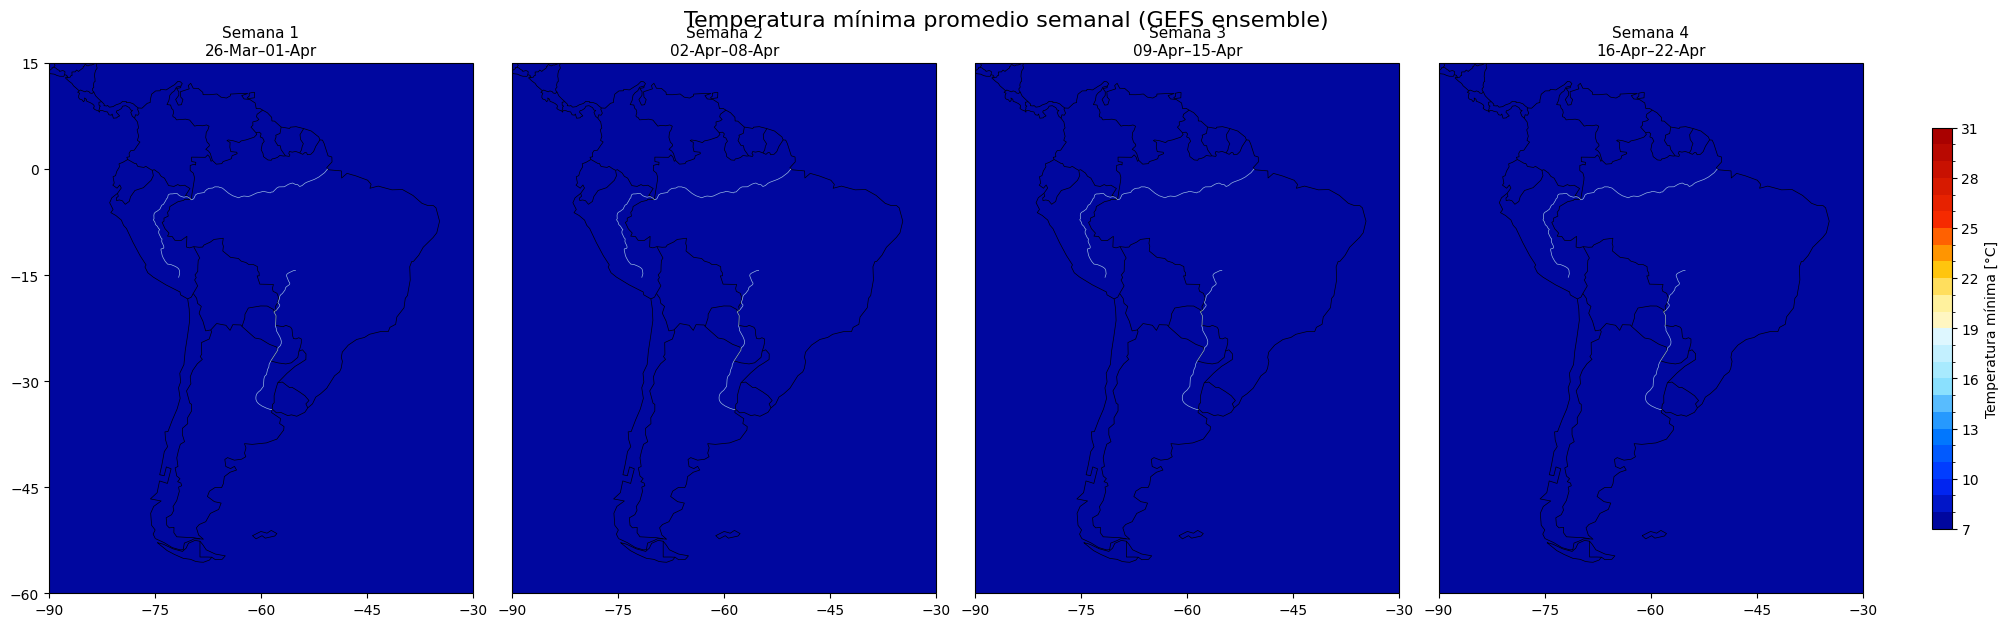

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

# 1️⃣ Abrir dataset GEFS desde Zarr
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# 2️⃣ Fecha más reciente
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init))

# 3️⃣ Subconjunto Sudamérica y promedio ensemble
ds_mean = (
    ds.sel(init_time=latest_init)
    .sel(latitude=slice(15, -60), longitude=slice(-90, -30))
    .mean(dim="ensemble_member")
)

# 4️⃣ Hasta 28 días para cubrir 4 semanas
ds_weeks = ds_mean.sel(lead_time=slice("0h", "27d"))

# 5️⃣ Variable: temperatura mínima
tmin = ds_weeks["minimum_temperature_2m"]

# 6️⃣ Coordenada temporal real
forecast_time = ds_weeks.init_time + ds_weeks.lead_time
tmin = tmin.assign_coords(forecast_time=forecast_time)
tmin = tmin.swap_dims({"lead_time": "forecast_time"})

# 7️⃣ Agrupar por fecha calendario y hacer promedio diario
tmin_daily = tmin.groupby("forecast_time.date").mean(dim="forecast_time")

# 8️⃣ Preparar semanas (promedio semanal)
semanas = {
    "Semana 1": slice(0, 7),
    "Semana 2": slice(7, 14),
    "Semana 3": slice(14, 21),
    "Semana 4": slice(21, 28),
}

# 9️⃣ Paleta de colores personalizada para temperatura mínima [°C]
colors_temp = ['#00079F', '#0116C8', '#0125F0', '#013DFF', '#015AFE', '#0177FE', '#2699FE', '#58BCFE',
               '#8AE0FE', '#A8EAFE', '#C3F0FF', '#DEF7FF',  '#FFF6C1', '#FFF19D', '#FFDE5D', '#FFC50E',
               '#FF9501', '#FF6101', '#F62A00', '#E72200', '#D71A00', '#C81101', '#B80901', '#A90100']
cmap_temp = mcolors.ListedColormap(colors_temp)
norm_temp = mcolors.BoundaryNorm(boundaries=np.arange(7, 32, 1), ncolors=len(colors_temp))

# 🔟 Crear figura
fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
plt.subplots_adjust(wspace=0.02)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    # Promedio semanal (en K), convertir a °C
    tmin_week = tmin_daily.isel(date=rango).mean(dim="date") - 273.15

    # Fechas de la semana
    week_dates = tmin_daily.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b")
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b")

    # Mapa base
    ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)

    # Etiquetas de ejes
    if i == 0:
        ax.set_yticks(range(-60, 16, 15), crs=ccrs.PlateCarree())
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())
        ax.tick_params(labelleft=True, labelbottom=True)
    else:
        ax.tick_params(labelleft=False, labelbottom=True)
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())

    # Graficar temperatura mínima
    mesh = ax.pcolormesh(
        tmin_week.longitude,
        tmin_week.latitude,
        tmin_week,
        cmap=cmap_temp,
        norm=norm_temp,
        shading="auto"
    )

    ax.set_title(f"{semana}\n{start_date}–{end_date}", fontsize=11)

# Colorbar común
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Temperatura mínima [°C]")

# Título principal
plt.suptitle("Temperatura mínima promedio semanal (GEFS ensemble)", fontsize=16, y=1.02)
plt.show()


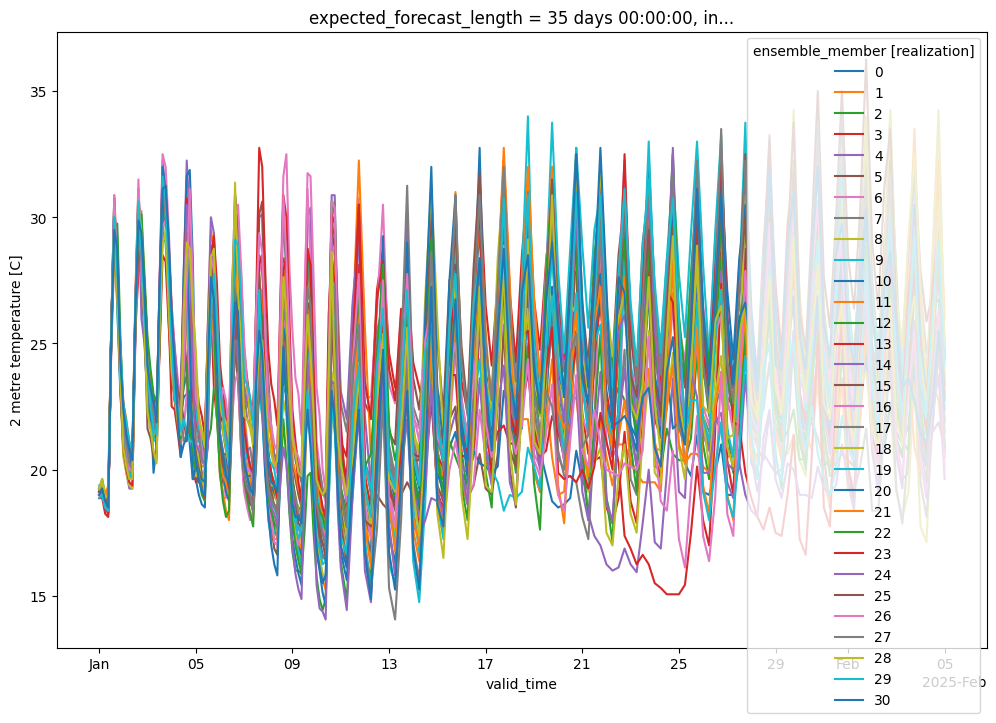

In [ ]:
# Plot the ensemble traces of the 2025-01-01 forecast at a point on the earth
plot_ds = ds.sel(init_time="2025-01-01T00", latitude=-23.5, longitude=-46.6, method="nearest")  # São Paulo, Brazil
_ = plot_ds["temperature_2m"].plot(x="valid_time", hue="ensemble_member", figsize=(12, 8))

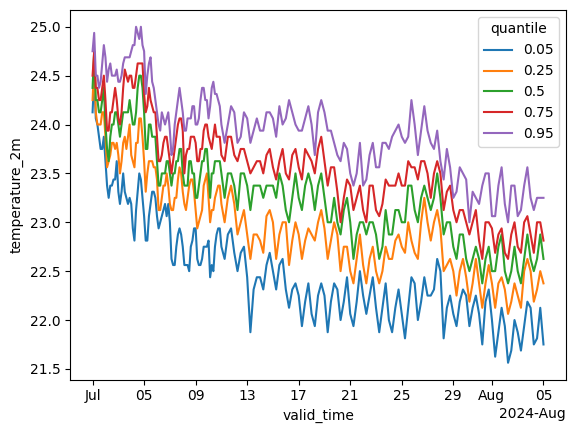

In [ ]:
# Plot a summary of the ensemble distribution using quantiles
plot_ds = ds.sel(init_time="2024-07-01T00", latitude=0, longitude=0)
(
    plot_ds["temperature_2m"]
    .quantile([0.05, 0.25, 0.5, 0.75, 0.95], dim="ensemble_member")
    .plot(x="valid_time", hue="quantile")
)

In [ ]:
# The following larger area examples run faster using dask which happens by default if you omit chunks=None
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", decode_timedelta=True)

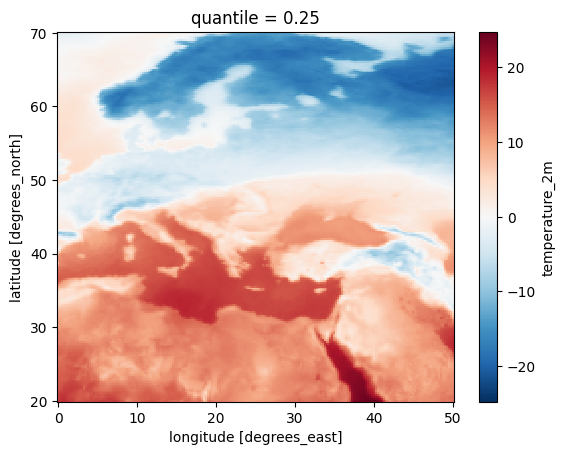

In [ ]:
# Calculate a quantile across ensemble members and display the result as a map
(
    ds["temperature_2m"]
    .sel(init_time="2025-01-01T00")
    .sel(lead_time="7d")
    .sel(latitude=slice(70, 20), longitude=slice(0, 50))
    .quantile(0.25, dim="ensemble_member") # 25% chance it gets colder than this
    .plot()
)

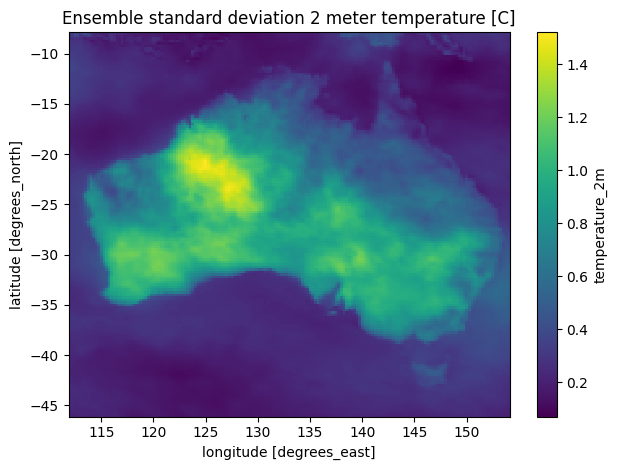

In [ ]:
# Highlight areas of uncertainty in temperature forecast over the first 7 days of 2025

import matplotlib.pyplot as plt

plot_ds = (
    ds.sel(init_time="2024-03-01T00")
    .sel(latitude=slice(-8, -46), longitude=slice(112, 154))  # Australia
    .sel(lead_time=slice("0h", "6d")).mean(dim="lead_time")  # Average the first week of the forecast
)

# Standard deviation across ensemble members to highlight regions of forecast uncertainty
plot_ds["temperature_2m"].std(dim="ensemble_member").plot()
plt.title(f"Ensemble standard deviation 2 meter temperature [{ds['temperature_2m'].attrs['units']}]")

plt.tight_layout()